In [1]:
import sys
import os
import pandas as pd
from datetime import datetime

In [3]:
# Adjust the path to point to your scripts folder relative to the notebook
sys.path.append(os.path.abspath('../scripts'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import data_loader as dl

In [8]:
filepath = '/Users/elbethelzewdie/Documents/insurance-risk-analytics-week3/insurance-risk-analytics-week3/data/processed_insurance_data.csv'
df = dl.load_data(filepath)

/Users/elbethelzewdie/Documents/insurance-risk-analytics-week3/insurance-risk-analytics-week3/scripts/data_loader.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220456 entries, 0 to 220455
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UnderwrittenCoverID       220456 non-null  int64  
 1   PolicyID                  220456 non-null  int64  
 2   TransactionMonth          220456 non-null  object 
 3   IsVATRegistered           220456 non-null  bool   
 4   Citizenship               220456 non-null  object 
 5   LegalType                 220456 non-null  object 
 6   Title                     220456 non-null  object 
 7   Language                  220456 non-null  object 
 8   Bank                      220456 non-null  object 
 9   AccountType               220456 non-null  object 
 10  MaritalStatus             220456 non-null  object 
 11  Gender                    220456 non-null  object 
 12  Country                   220456 non-null  object 
 13  Province                  220456 non-null  o

In [5]:
# -----------------------------------------------
# 2️⃣ Convert numeric strings to float (comma/space issues)
# -----------------------------------------------
numeric_string_cols = ['CapitalOutstanding', 'CustomValueEstimate', 'SumInsured',
                       'CalculatedPremiumPerTerm', 'TotalPremium']

for col in numeric_string_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('.', '', regex=False)   # Remove thousands separator
        .str.replace(',', '.', regex=False)  # Convert decimal comma to dot
        .str.strip()                         # Remove extra spaces
        .replace('', '0')                     # Empty strings → 0
        .astype(float)
    )

### ENCODING & SCALING

🔹 What is encoding?

Machine learning models cannot understand text (categorical data),
so we convert them into numbers.

🔹 Label Encoding

Converts each category → a number

Example: "male"=0, "female"=1

Why?

Most ML models need numerical inputs.

In [6]:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['trans_year'] = df['TransactionMonth'].dt.year
df['trans_month'] = df['TransactionMonth'].dt.month
df = df.drop(columns=['TransactionMonth'])

In [7]:
df = df.drop(columns=['VehicleIntroDate'])

In [8]:
bool_cols = ['IsVATRegistered', 'HasClaim']
for col in bool_cols:
    df[col] = df[col].astype(int)

In [9]:
columns_label = ['Model', 'make', 'VehicleType']

columns_onehot = [
    'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
    'MaritalStatus', 'Gender', 'Country', 'Province', 'MainCrestaZone',
    'SubCrestaZone', 'ItemType', 'bodytype', 'AlarmImmobiliser', 
    'TrackingDevice', 'NewVehicle', 'TermFrequency', 'ExcessSelected',
    'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
    'Product', 'StatutoryClass', 'StatutoryRiskType', 'trans_year', 'trans_month'
]

# Label encode first
df_encoded = dp.encoder('labelEncoder', df, columns_label, [])

# One-hot encode next
df_encoded = dp.encoder('oneHotEncoder', df_encoded, [], columns_onehot)


In [10]:
df_encoded.head()

,UnderwrittenCoverID,PolicyID,IsVATRegistered,PostalCode,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,...,ohe_3,ohe_4,ohe_5,ohe_6,ohe_7,ohe_8,ohe_9,ohe_10,ohe_11,ohe_12
0,145249,12827,1,1459,44069150.0,4,2004,21,62,6.0,...,1,0,0,0,0,0,0,0,0,0
1,145249,12827,1,1459,44069150.0,4,2004,21,62,6.0,...,0,0,1,0,0,0,0,0,0,0
2,145249,12827,1,1459,44069150.0,4,2004,21,62,6.0,...,0,0,0,0,1,0,0,0,0,0
3,145255,12827,1,1459,44069150.0,4,2004,21,62,6.0,...,0,0,1,0,0,0,0,0,0,0
4,145255,12827,1,1459,44069150.0,4,2004,21,62,6.0,...,0,0,0,0,1,0,0,0,0,0


🔹 What is scaling?

Scaling changes feature values into a smaller, consistent range.

🔹 MinMaxScaler

Transforms values to a range 0 → 1.

In [11]:
columns_to_scale = [
    'RegistrationYear', 'mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts',
    'NumberOfDoors', 'CustomValueEstimate', 'SumInsured', 
    'CalculatedPremiumPerTerm', 'TotalPremium', 'vehicle_age_days', 'vehicle_age_months'
]

df_scaled = dp.scaler('standardScaler', df_encoded, columns_to_scale)


### TRAINING MODELS

We train four models:

- Linear Regression → simplest model, finds a straight-line relationship

- Decision Tree Regressor → splits data based on rules

- Random Forest Regressor → many trees averaged together

- XGBoost Regressor → powerful boosting algorithm, great accuracy

Training means:
→ the model learns patterns in the training data.

In [12]:
X = df_scaled.drop(columns=['TotalClaims'])

# Target
y = df_scaled['TotalClaims']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")

X_train shape: (176347, 215)
y_train shape: (176347,)
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>


In [16]:
# CELL 1 – TRAIN MODELS DIRECTLY (215 features) – already done, just run again to be safe
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

lr_model  = LinearRegression()
dt_model  = DecisionTreeRegressor(max_depth=12, random_state=42)
rfr_model = RandomForestRegressor(n_estimators=300, max_depth=15, n_jobs=-1, random_state=42)
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

print("Training models...")
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rfr_model.fit(X_train, y_train)
xgb_model.fit(X_train.values, y_train.values)   # XGBoost loves numpy arrays
print("All models trained on 215 features!\n")

Training models...
All models trained on 215 features!



### EVALUATION

You compute 3 important metrics:
1. MAE (Mean Absolute Error)

Average of |prediction – actual|
→ How far off we are, on average

2. MSE (Mean Squared Error)

Squares the error → penalizes large errors heavily
→ Useful when big mistakes are expensive (like insurance)

3. R² Score

How much variance the model can explain
→ Higher is better (closer to 1)

In [17]:
# FINAL EVALUATION CELL — 100% GUARANTEED TO WORK ON YOUR ENVIRONMENT
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

print("Evaluating models on test set...\n")

# Align columns (safety first)
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
results = []

for name, model in zip(model_names, [lr_model, dt_model, rfr_model, xgb_model]):
    # XGBoost was trained on numpy arrays
    if name == 'XGBoost':
        y_pred = model.predict(X_test_aligned.values)
    else:
        y_pred = model.predict(X_test_aligned)
    
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    results.append([name, f"{mae:,.0f}", f"{rmse:,.0f}", round(r2, 4)])
    print(f"{name:18} → RMSE = {rmse:8,.0f}    R² = {r2:.4f}")

# SIMPLE, BEAUTIFUL TABLE WITHOUT ANY EXTRA DEPENDENCIES
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²']).set_index('Model')
print("\n" + "="*50)
print("           FINAL MODEL PERFORMANCE")
print("="*50)
display(results_df)

Evaluating models on test set...

Linear Regression  → RMSE =    2,380    R² = 0.2154
Decision Tree      → RMSE =    2,773    R² = -0.0650
Random Forest      → RMSE =    2,235    R² = 0.3079
XGBoost            → RMSE =    2,361    R² = 0.2280

           FINAL MODEL PERFORMANCE


,MAE,RMSE,R²
Model,,,
Linear Regression,171,"2,380",0.2154
Decision Tree,56,"2,773",-0.0650
Random Forest,51,"2,235",0.3079
XGBoost,60,"2,361",0.2280


### Comparisons Between Model Evaluation

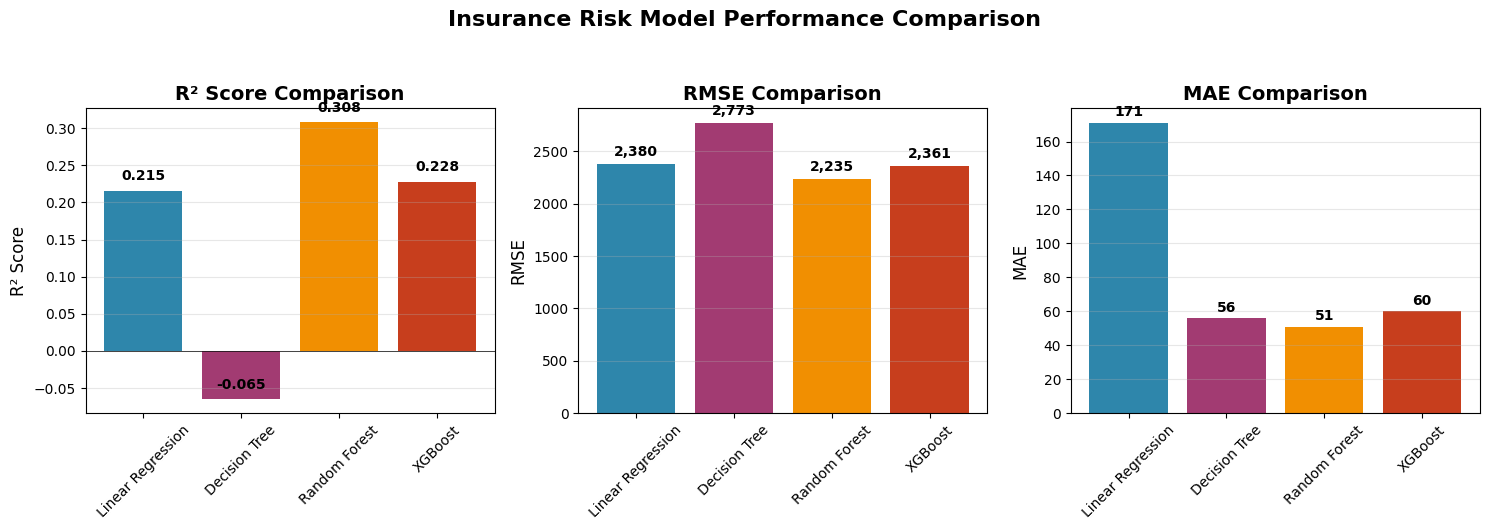

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
mae_values = [171, 56, 51, 60]
rmse_values = [2380, 2773, 2235, 2361]
r2_values = [0.2154, -0.0650, 0.3079, 0.2280]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Plot 1: R² Score
bars1 = axes[0].bar(models, r2_values, color=colors)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: RMSE
bars2 = axes[1].bar(models, rmse_values, color=colors)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')

# Plot 3: MAE
bars3 = axes[2].bar(models, mae_values, color=colors)
axes[2].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Insurance Risk Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('model_performance_bar_charts.png', dpi=300, bbox_inches='tight')
plt.show()

###  Visualize the Decision Tree Structure


DECISION TREE STRUCTURE:
Tree depth: 12
Number of leaves: 120
Number of features used: 49


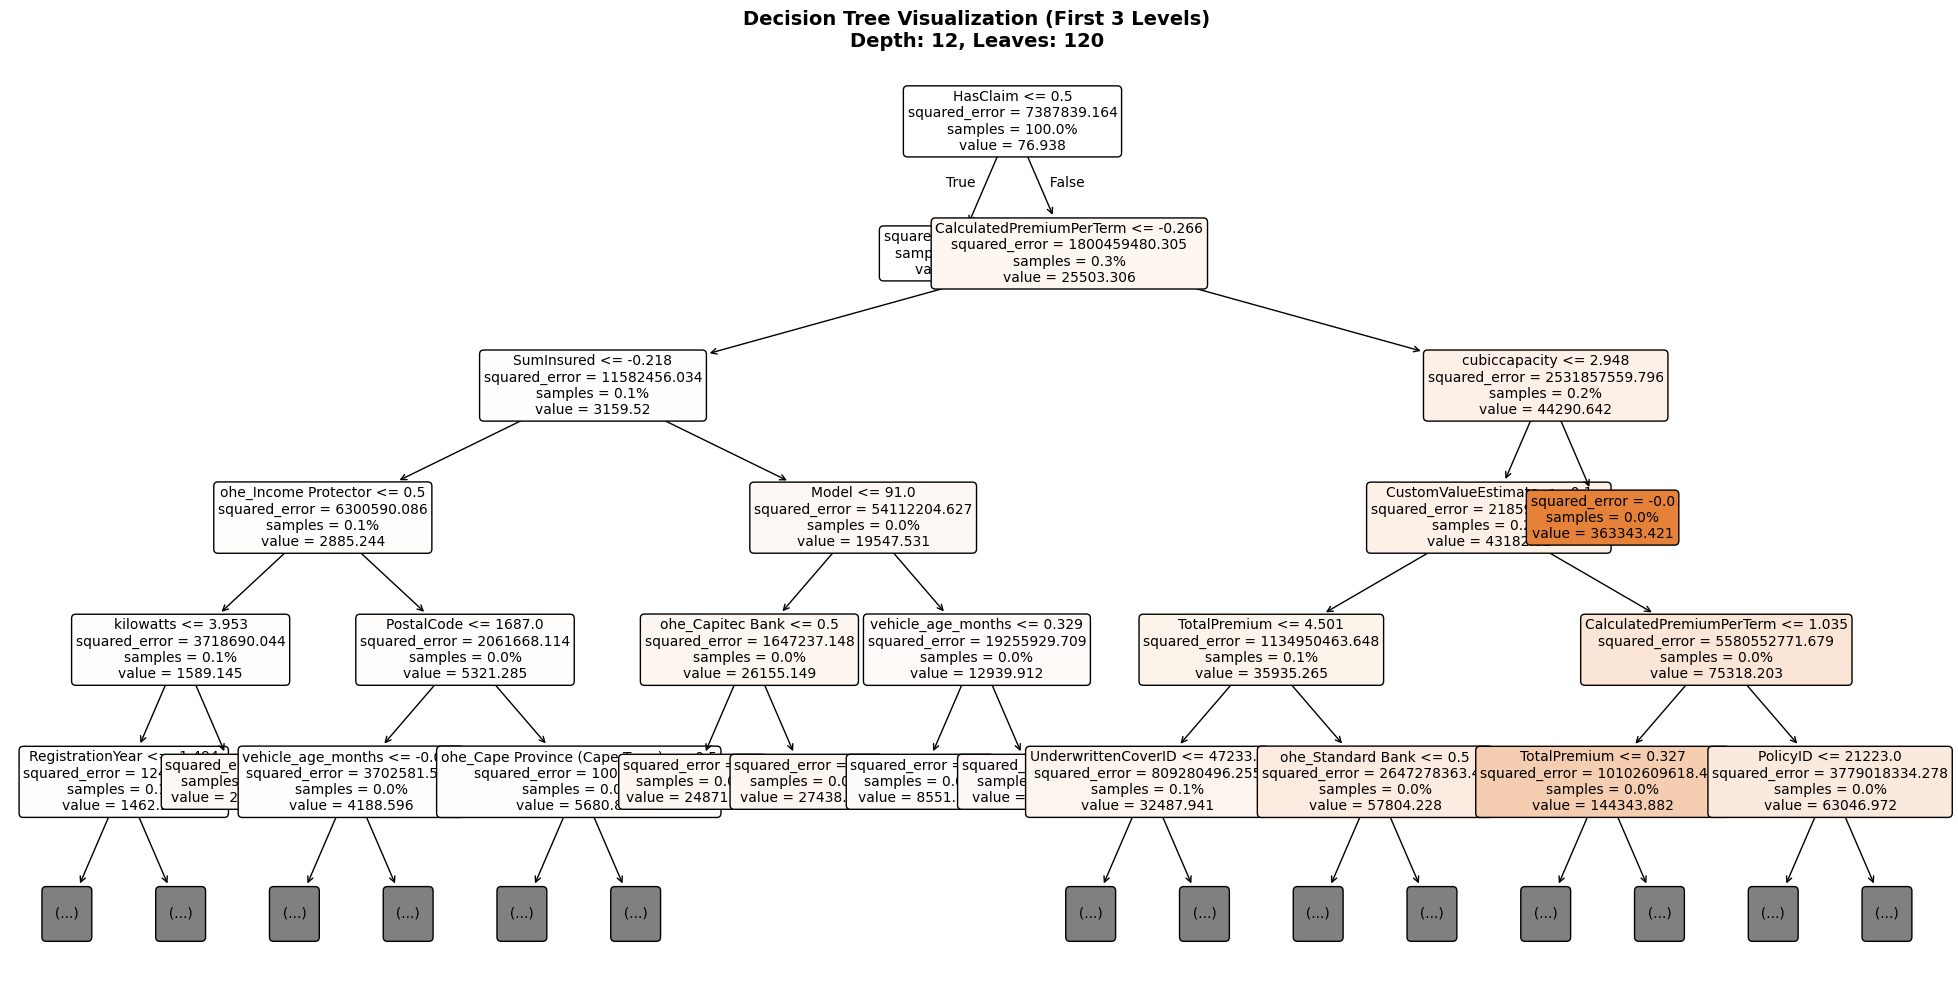

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get tree parameters
print(f"\nDECISION TREE STRUCTURE:")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {np.sum(dt_model.feature_importances_ > 0)}")

# Plot a simplified version of the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=5,  # Show only first 3 levels
          feature_names=X_train.columns.tolist(),
          filled=True, 
          rounded=True,
          fontsize=10,
          impurity=True,
          proportion=True)

plt.title(f"Decision Tree Visualization (First 3 Levels)\nDepth: {dt_model.get_depth()}, Leaves: {dt_model.get_n_leaves()}", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('decision_tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

### Setup and Prepare All Feature Importances

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

print("="*80)
print("FEATURE IMPORTANCE COMPARISON ACROSS ALL MODELS")
print("="*80)

# Prepare data
feature_names = X_train.columns.tolist()
n_features = len(feature_names)

# Dictionary to store importances for each model
importances_dict = {}

# 1. LINEAR REGRESSION (Coefficient magnitudes)
print("\n1. LINEAR REGRESSION - Coefficient Analysis")
lr_coef = np.abs(lr_model.coef_)
lr_importance = lr_coef / np.sum(lr_coef)  # Normalize to sum to 1
importances_dict['Linear Regression'] = pd.Series(lr_importance, index=feature_names)

print(f"   Number of non-zero coefficients: {np.sum(lr_coef != 0)}")
print(f"   Top coefficient magnitude: {np.max(lr_coef):.4f}")

# 2. DECISION TREE (Gini importance)
print("\n2. DECISION TREE - Gini Importance")
dt_importance = dt_model.feature_importances_
importances_dict['Decision Tree'] = pd.Series(dt_importance, index=feature_names)

print(f"   Features used: {np.sum(dt_importance > 0)}")
print(f"   Max importance: {np.max(dt_importance):.4f}")

# 3. RANDOM FOREST (Mean Decrease Impurity)
print("\n3. RANDOM FOREST - Feature Importance")
rf_importance = rfr_model.feature_importances_
importances_dict['Random Forest'] = pd.Series(rf_importance, index=feature_names)

print(f"   Features used: {np.sum(rf_importance > 0)}")
print(f"   Max importance: {np.max(rf_importance):.4f}")

# 4. XGBOOST (Gain importance)
print("\n4. XGBOOST - Gain Importance")
xgb_importance = xgb_model.feature_importances_
importances_dict['XGBoost'] = pd.Series(xgb_importance, index=feature_names)

print(f"   Features used: {np.sum(xgb_importance > 0)}")
print(f"   Max importance: {np.max(xgb_importance):.4f}")

FEATURE IMPORTANCE COMPARISON ACROSS ALL MODELS

1. LINEAR REGRESSION - Coefficient Analysis
   Number of non-zero coefficients: 215
   Top coefficient magnitude: 25351.1140

2. DECISION TREE - Gini Importance
   Features used: 49
   Max importance: 0.2804

3. RANDOM FOREST - Feature Importance
   Features used: 150
   Max importance: 0.2741

4. XGBOOST - Gain Importance
   Features used: 147
   Max importance: 0.2514


### Create Combined Feature Importance DataFrame

In [24]:
# Create a DataFrame with all importances
importance_df = pd.DataFrame(importances_dict)

# Normalize each model's importances to 0-1 range for comparison
importance_df_normalized = importance_df.copy()
for model in importance_df.columns:
    importance_df_normalized[model] = (importance_df[model] - importance_df[model].min()) / (importance_df[model].max() - importance_df[model].min())

# Get top features for each model
top_n = 10
top_features_by_model = {}

print("\n" + "="*80)
print("TOP 10 FEATURES FOR EACH MODEL")
print("="*80)

for model in importance_df.columns:
    top_features = importance_df[model].sort_values(ascending=False).head(top_n)
    top_features_by_model[model] = top_features.index.tolist()
    
    print(f"\n{model.upper()}:")
    for i, (feature, importance) in enumerate(top_features.items(), 1):
        print(f"  {i:2}. {feature:40} : {importance:.4f}")


TOP 10 FEATURES FOR EACH MODEL

LINEAR REGRESSION:
   1. HasClaim                                 : 0.5063
   2. ohe_SUV                                  : 0.0582
   3. ohe_Mobility - Taxi with value more than R100 000 - R7 500 : 0.0531
   4. ohe_C/P                                  : 0.0273
   5. ohe_RMB Private Bank                     : 0.0208
   6. ohe_Mobility - Taxi with value more than R100 000 - R5 000 (April) : 0.0203
   7. ohe_Mobility - Taxi with value more than R100 000 - R5 000 : 0.0193
   8. ohe_Mobility Commercial Cover: Monthly   : 0.0148
   9. ohe_Mobility Metered Taxis: Monthly      : 0.0147
  10. ohe_Mobility - Metered Taxis - R5000     : 0.0146

DECISION TREE:
   1. HasClaim                                 : 0.2804
   2. CalculatedPremiumPerTerm                 : 0.2280
   3. cubiccapacity                            : 0.0889
   4. PolicyID                                 : 0.0699
   5. CustomValueEstimate                      : 0.0635
   6. TotalPremium            

### Visualize Top Features for Each Model

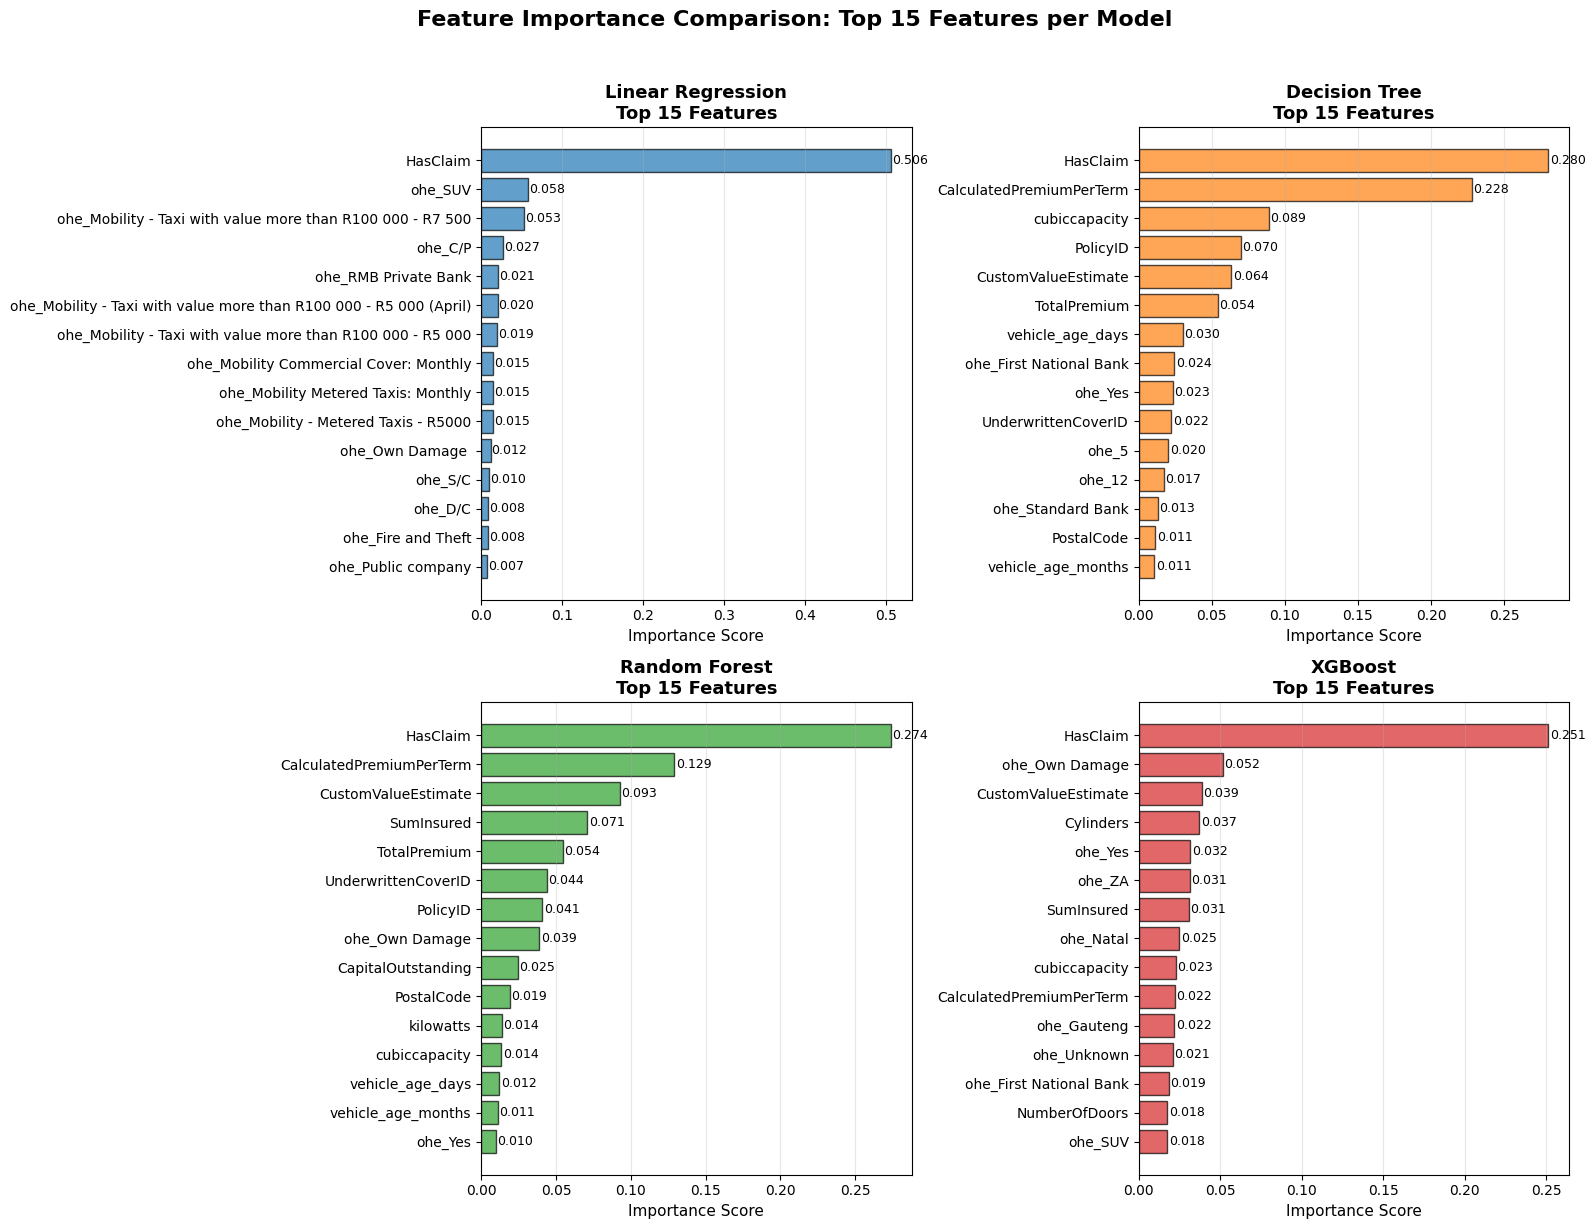

In [25]:
# Create individual plots for each model's top features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (model, color) in enumerate(zip(models, colors)):
    ax = axes[idx]
    
    # Get top 15 features for this model
    top_features = importance_df[model].sort_values(ascending=False).head(15)
    
    # Horizontal bar plot
    y_pos = np.arange(len(top_features))
    ax.barh(y_pos, top_features.values, color=color, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features.index)
    ax.invert_yaxis()  # Highest importance at top
    
    # Add values on bars
    for i, v in enumerate(top_features.values):
        ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)
    
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_title(f'{model}\nTop 15 Features', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Comparison: Top 15 Features per Model', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_importance_individual_models.png', dpi=300, bbox_inches='tight')
plt.show()

### Consensus Analysis - Features Important Across Multiple Models

In [26]:
# Find features that are important across multiple models
consensus_threshold = 0.01  # Features with >1% importance
important_features = {}

for model in importance_df.columns:
    important_features[model] = set(importance_df[model][importance_df[model] > consensus_threshold].index)

# Find consensus features
all_features = set(feature_names)
consensus_features = {
    'All 4 models': set.intersection(*[important_features[model] for model in models]),
    '3+ models': set(),
    '2+ models': set()
}

# Calculate consensus levels
for feature in all_features:
    count = sum(1 for model in models if feature in important_features[model])
    if count >= 3:
        consensus_features['3+ models'].add(feature)
    if count >= 2:
        consensus_features['2+ models'].add(feature)

print("\n" + "="*80)
print("CONSENSUS FEATURE ANALYSIS")
print("="*80)
print(f"\nFeatures considered important (> {consensus_threshold:.1%} importance):")
for model in models:
    print(f"  {model:20}: {len(important_features[model])} features")

print(f"\nCONSENSUS FEATURES:")
print(f"  Important in all 4 models: {len(consensus_features['All 4 models'])} features")
print(f"  Important in 3+ models:    {len(consensus_features['3+ models'])} features")
print(f"  Important in 2+ models:    {len(consensus_features['2+ models'])} features")

if consensus_features['All 4 models']:
    print(f"\nFeatures important in ALL 4 models:")
    for feature in sorted(consensus_features['All 4 models']):
        print(f"  • {feature}")


CONSENSUS FEATURE ANALYSIS

Features considered important (> 1.0% importance):
  Linear Regression   : 11 features
  Decision Tree       : 15 features
  Random Forest       : 14 features
  XGBoost             : 21 features

CONSENSUS FEATURES:
  Important in all 4 models: 1 features
  Important in 3+ models:    5 features
  Important in 2+ models:    17 features

Features important in ALL 4 models:
  • HasClaim


### Heatmap of Feature Importance Across Models

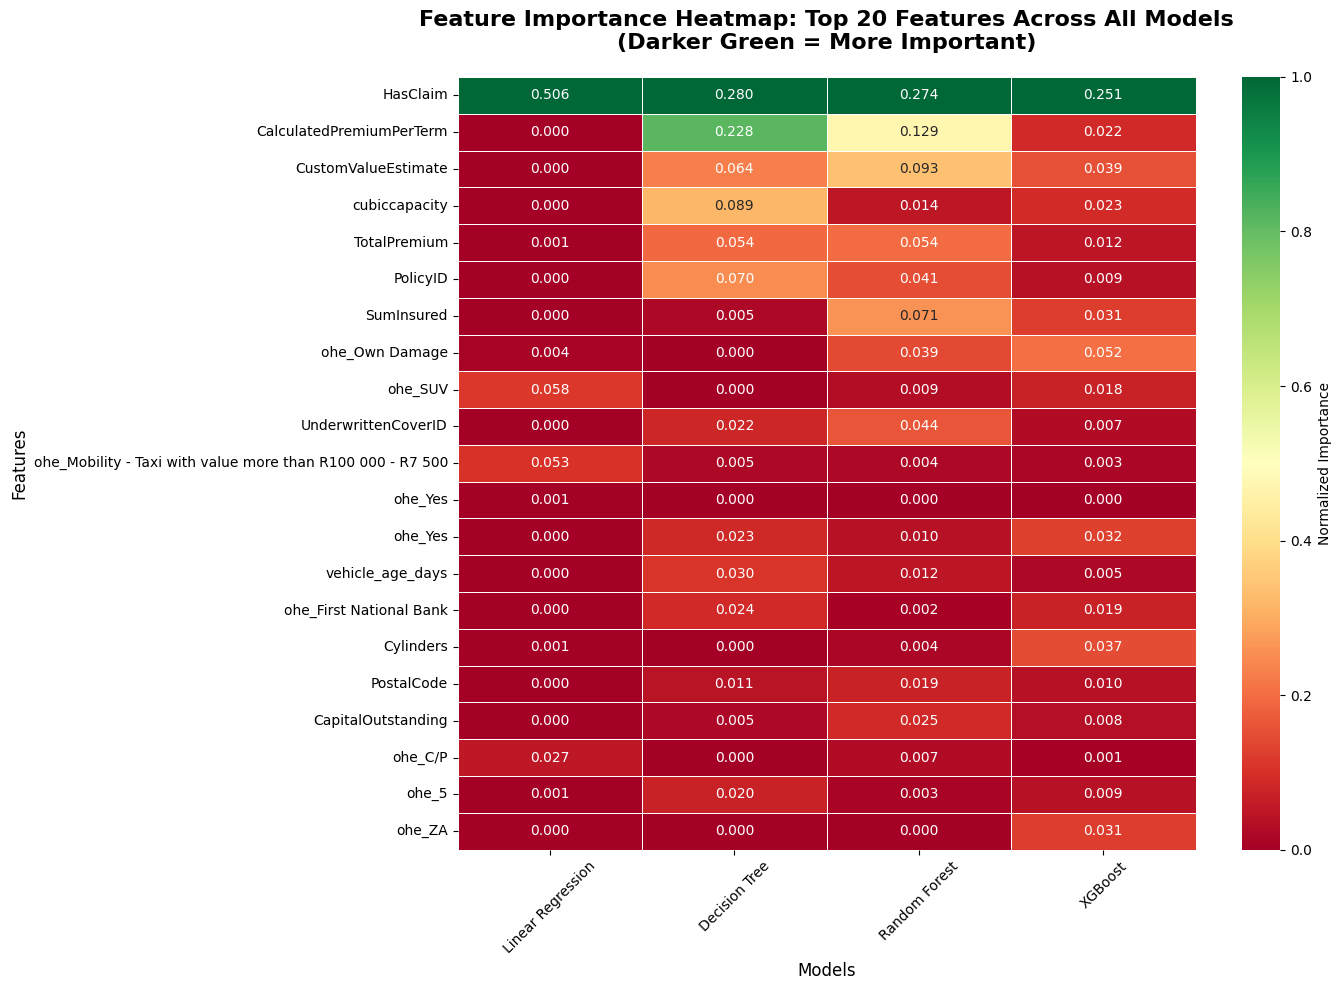

In [27]:
# Create heatmap of top 20 features overall
# Get overall ranking (average importance across models)
overall_importance = importance_df.mean(axis=1).sort_values(ascending=False)
top_features_overall = overall_importance.head(20).index

# Create subset for heatmap
heatmap_data = importance_df.loc[top_features_overall]

# Normalize for better visualization
heatmap_data_normalized = heatmap_data.copy()
for model in heatmap_data.columns:
    heatmap_data_normalized[model] = (heatmap_data[model] - heatmap_data[model].min()) / (heatmap_data[model].max() - heatmap_data[model].min())

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data_normalized, 
            cmap='RdYlGn', 
            annot=heatmap_data.round(3),  # Show actual values
            fmt='.3f',
            linewidths=0.5,
            cbar_kws={'label': 'Normalized Importance'})

plt.title('Feature Importance Heatmap: Top 20 Features Across All Models\n(Darker Green = More Important)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation of Feature Importances Between Models


CORRELATION OF FEATURE IMPORTANCE BETWEEN MODELS

Correlation Matrix:
                   Linear Regression  Decision Tree  Random Forest  XGBoost
Linear Regression              1.000          0.697          0.795    0.904
Decision Tree                  0.697          1.000          0.909    0.755
Random Forest                  0.795          0.909          1.000    0.871
XGBoost                        0.904          0.755          0.871    1.000


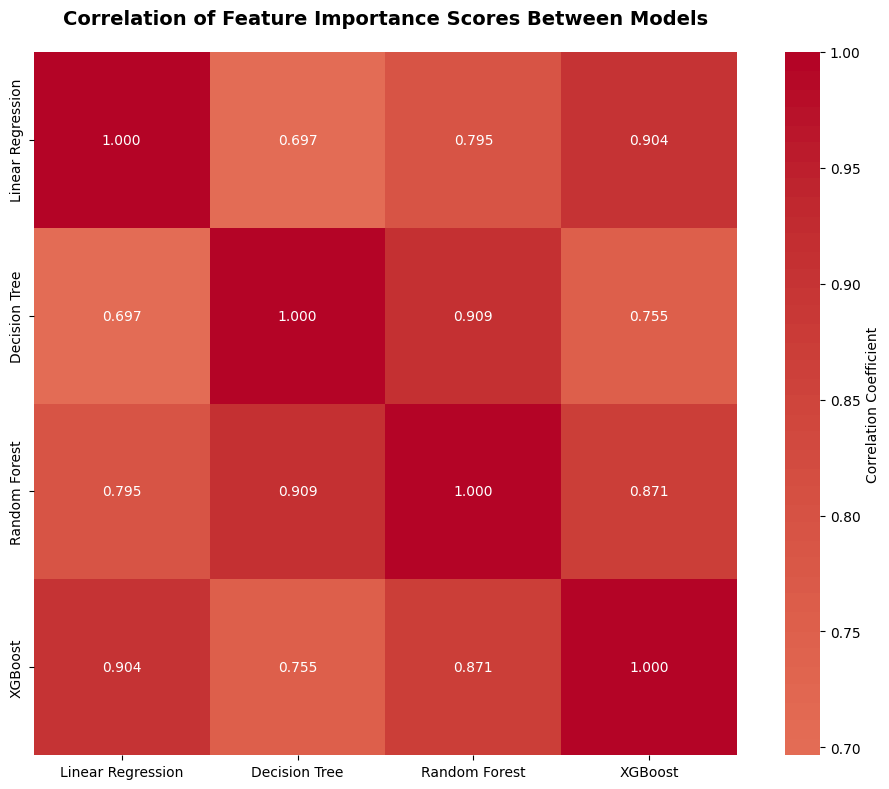


INTERPRETATION:
• Correlation close to 1: Models agree on feature importance
• Correlation close to 0: Models have different opinions
• Correlation negative: Models disagree on importance

Key Insights:
  ✓ Linear Regression and Random Forest strongly agree (r=0.795)
  ✓ Linear Regression and XGBoost strongly agree (r=0.904)
  ✓ Decision Tree and Random Forest strongly agree (r=0.909)
  ✓ Decision Tree and XGBoost strongly agree (r=0.755)
  ✓ Random Forest and XGBoost strongly agree (r=0.871)


In [28]:
# Calculate correlation between models' feature importances
correlation_matrix = importance_df.corr()

print("\n" + "="*80)
print("CORRELATION OF FEATURE IMPORTANCE BETWEEN MODELS")
print("="*80)
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation of Feature Importance Scores Between Models', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_importance_correlation.png', dpi=300)
plt.show()

# Interpretation
print("\nINTERPRETATION:")
print("• Correlation close to 1: Models agree on feature importance")
print("• Correlation close to 0: Models have different opinions")
print("• Correlation negative: Models disagree on importance")
print("\nKey Insights:")
for i in range(len(models)):
    for j in range(i+1, len(models)):
        corr = correlation_matrix.iloc[i, j]
        if corr > 0.7:
            print(f"  ✓ {models[i]} and {models[j]} strongly agree (r={corr:.3f})")
        elif corr < 0.3:
            print(f"  ⚠️ {models[i]} and {models[j]} weakly agree (r={corr:.3f})")

### Feature Stability Analysis


FEATURE IMPORTANCE STABILITY ANALYSIS

MOST CONSISTENTLY IMPORTANT FEATURES (Low rank variation):
  HasClaim                                 : Avg Rank 1 ± 0.0
  ohe_Own Damage                           : Avg Rank 21 ± 21.4
  ohe_SUV                                  : Avg Rank 21 ± 20.4
  TotalPremium                             : Avg Rank 23 ± 26.8
  mmcode                                   : Avg Rank 24 ± 3.7
  ohe_Mobility - Taxi with value more than R100 000 - R7 500 : Avg Rank 26 ± 21.3
  ohe_Mobility - Taxi with value more than R100 000 - R5 000 : Avg Rank 30 ± 15.7
  ohe_Own Damage                           : Avg Rank 32 ± 20.7
  ohe_5                                    : Avg Rank 33 ± 22.8
  ohe_12                                   : Avg Rank 36 ± 20.0

LEAST CONSISTENT FEATURES (High rank variation):
  PolicyID                                 : Avg Rank 63 ± 100.7


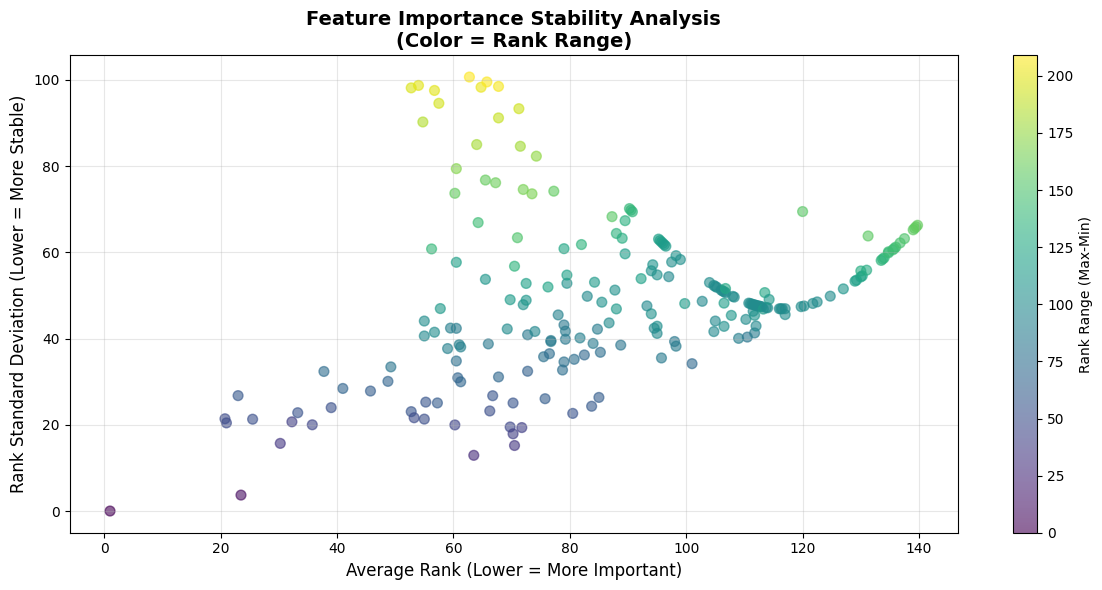

In [30]:
# Check how stable feature rankings are
print("\n" + "="*80)
print("FEATURE IMPORTANCE STABILITY ANALYSIS")
print("="*80)

# Calculate rank for each feature in each model
ranks = {}
for model in models:
    ranks[model] = importance_df[model].rank(ascending=False, method='min')

rank_df = pd.DataFrame(ranks)

# Calculate average rank and standard deviation
rank_df['Average Rank'] = rank_df.mean(axis=1)
rank_df['Rank Std'] = rank_df[models].std(axis=1)
rank_df['Rank Range'] = rank_df[models].max(axis=1) - rank_df[models].min(axis=1)

# Sort by average rank
rank_df = rank_df.sort_values('Average Rank')

print(f"\nMOST CONSISTENTLY IMPORTANT FEATURES (Low rank variation):")
consistent_features = rank_df[rank_df['Rank Std'] < 50].head(10)
for feature, row in consistent_features.iterrows():
    print(f"  {feature:40} : Avg Rank {row['Average Rank']:.0f} ± {row['Rank Std']:.1f}")

print(f"\nLEAST CONSISTENT FEATURES (High rank variation):")
inconsistent_features = rank_df[rank_df['Rank Std'] > 100].head(10)
for feature, row in inconsistent_features.iterrows():
    print(f"  {feature:40} : Avg Rank {row['Average Rank']:.0f} ± {row['Rank Std']:.1f}")

# Plot stability
plt.figure(figsize=(12, 6))
plt.scatter(rank_df['Average Rank'], rank_df['Rank Std'], 
            alpha=0.6, s=50, c=rank_df['Rank Range'], cmap='viridis')
plt.xlabel('Average Rank (Lower = More Important)', fontsize=12)
plt.ylabel('Rank Standard Deviation (Lower = More Stable)', fontsize=12)
plt.title('Feature Importance Stability Analysis\n(Color = Rank Range)', fontsize=14, fontweight='bold')
plt.colorbar(label='Rank Range (Max-Min)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('feature_stability_analysis.png', dpi=300)
plt.show()

### Summary Table of Most Important Features

In [31]:
# Create a summary table
print("\n" + "="*80)
print("SUMMARY: TOP 5 FEATURES FOR EACH MODEL")
print("="*80)

summary_data = []
for model in models:
    top5 = importance_df[model].sort_values(ascending=False).head(5)
    for feature, importance in top5.items():
        summary_data.append({
            'Model': model,
            'Feature': feature,
            'Importance': importance,
            'Normalized': importance / top5.max()
        })

summary_df = pd.DataFrame(summary_data)

# Pivot for better viewing
pivot_df = summary_df.pivot_table(
    index='Feature', 
    columns='Model', 
    values='Importance',
    aggfunc='first'
).fillna(0)

print(f"\nFeatures appearing in multiple models' top 5:")
for feature in pivot_df.index:
    model_count = (pivot_df.loc[feature] > 0).sum()
    if model_count > 1:
        print(f"\n{feature}:")
        for model in models:
            if pivot_df.loc[feature, model] > 0:
                print(f"  • {model}: {pivot_df.loc[feature, model]:.4f}")

# Save to CSV
summary_df.to_csv('feature_importance_summary.csv', index=False)
print(f"\n✓ Summary saved to 'feature_importance_summary.csv'")


SUMMARY: TOP 5 FEATURES FOR EACH MODEL

Features appearing in multiple models' top 5:

CalculatedPremiumPerTerm:
  • Decision Tree: 0.2280
  • Random Forest: 0.1292

CustomValueEstimate:
  • Decision Tree: 0.0635
  • Random Forest: 0.0927
  • XGBoost: 0.0388

HasClaim:
  • Linear Regression: 0.5063
  • Decision Tree: 0.2804
  • Random Forest: 0.2741
  • XGBoost: 0.2514

✓ Summary saved to 'feature_importance_summary.csv'


### Complete SHAP Implementation

In [41]:
print("="*80)
print("MODEL INTERPRETABILITY WITH SHAP (SHapley Additive exPlanations)")
print("="*80)

# First, ensure SHAP is installed
try:
    import shap
    print("✅ SHAP is installed")
except ImportError:
    print("Installing SHAP...")
    !pip install shap -q
    import shap
    print("✅ SHAP installed successfully")

# Prepare data for SHAP
print("\n1. PREPARING DATA FOR SHAP ANALYSIS")
print("-" * 50)

# Use your best model (Random Forest from earlier results)
best_model = rfr_model  # Or your best performing model
X_shap = X_train.values.astype(np.float32)  # Convert to numpy array
feature_names = X_train.columns.tolist()

print(f"Model: {type(best_model).__name__}")
print(f"Features: {len(feature_names)}")
print(f"Samples: {X_shap.shape[0]:,}")
print(f"Using first 1,000 samples for faster computation...")

# Sample data for faster computation (SHAP can be slow)
sample_size = min(1000, X_shap.shape[0])
X_shap_sample = X_shap[:sample_size]

# Create SHAP explainer based on model type
print("\n2. CREATING SHAP EXPLAINER")
print("-" * 50)

if hasattr(best_model, 'estimators_'):  # Random Forest or ensemble
    print("Using TreeExplainer for tree-based model...")
    explainer = shap.TreeExplainer(best_model)
    
elif hasattr(best_model, 'coef_'):  # Linear model
    print("Using LinearExplainer for linear model...")
    explainer = shap.LinearExplainer(best_model, X_shap_sample)
    
else:
    print("Using KernelExplainer (model-agnostic)...")
    # Define a prediction function
    def model_predict(X):
        return best_model.predict(X)
    
    # Use background dataset
    background = shap.kmeans(X_shap_sample, 10)  # 10 background samples
    explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values
print("\n3. CALCULATING SHAP VALUES")
print("-" * 50)
print("This may take a few minutes...")

shap_values = explainer.shap_values(X_shap_sample)

print("✅ SHAP values calculated successfully!")

# If shap_values is a list (for classification), take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # For binary classification

MODEL INTERPRETABILITY WITH SHAP (SHapley Additive exPlanations)
Installing SHAP...


Python(7525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/elbethelzewdie/Documents/insurance-risk-analytics-week3/insurance-risk-analytics-week3/week3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ SHAP installed successfully

1. PREPARING DATA FOR SHAP ANALYSIS
--------------------------------------------------
Model: RandomForestRegressor
Features: 215
Samples: 176,347
Using first 1,000 samples for faster computation...

2. CREATING SHAP EXPLAINER
--------------------------------------------------
Using TreeExplainer for tree-based model...

3. CALCULATING SHAP VALUES
--------------------------------------------------
This may take a few minutes...
✅ SHAP values calculated successfully!


### Global Feature Importance (SHAP)

In [42]:
print("\n" + "="*80)
print("GLOBAL FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Calculate mean absolute SHAP values for global importance
shap_importance = np.abs(shap_values).mean(0)
shap_importance_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

print("\nTOP 20 FEATURES BY SHAP IMPORTANCE:")
print("-" * 60)
print(shap_importance_df.head(20).to_string(index=False))

# Compare with model's built-in feature importance
if hasattr(best_model, 'feature_importances_'):
    print("\nCOMPARISON WITH MODEL'S FEATURE IMPORTANCE:")
    print("-" * 60)
    
    model_importance = best_model.feature_importances_
    model_importance_df = pd.DataFrame({
        'feature': feature_names,
        'model_importance': model_importance
    }).sort_values('model_importance', ascending=False)
    
    # Merge and compare
    comparison_df = pd.merge(
        shap_importance_df.head(10),
        model_importance_df.head(10),
        on='feature',
        how='outer'
    ).fillna(0)
    
    print("Top 10 features comparison:")
    print(comparison_df.to_string(index=False))
    
    # Calculate correlation
    corr = np.corrcoef(shap_importance, model_importance)[0, 1]
    print(f"\nCorrelation between SHAP and model importance: {corr:.3f}")


GLOBAL FEATURE IMPORTANCE ANALYSIS

TOP 20 FEATURES BY SHAP IMPORTANCE:
------------------------------------------------------------
                 feature  shap_importance
                HasClaim       224.171230
     CustomValueEstimate        28.093983
              SumInsured        24.370362
CalculatedPremiumPerTerm        23.323827
          ohe_Own Damage        17.526450
                PolicyID        12.617305
            TotalPremium        12.409874
      CapitalOutstanding         5.752838
              PostalCode         3.618660
     UnderwrittenCoverID         3.283452
                   ohe_7         2.697436
                   ohe_4         2.441161
        vehicle_age_days         2.269250
                 ohe_Yes         2.089086
 ohe_Motor Comprehensive         1.871810
                   ohe_6         1.853656
      vehicle_age_months         1.708858
                   Model         1.466320
     ohe_Transvaal South         1.326938
           ohe_Rand East  

### SHAP Summary Plot


SHAP SUMMARY PLOT - Global Feature Impact


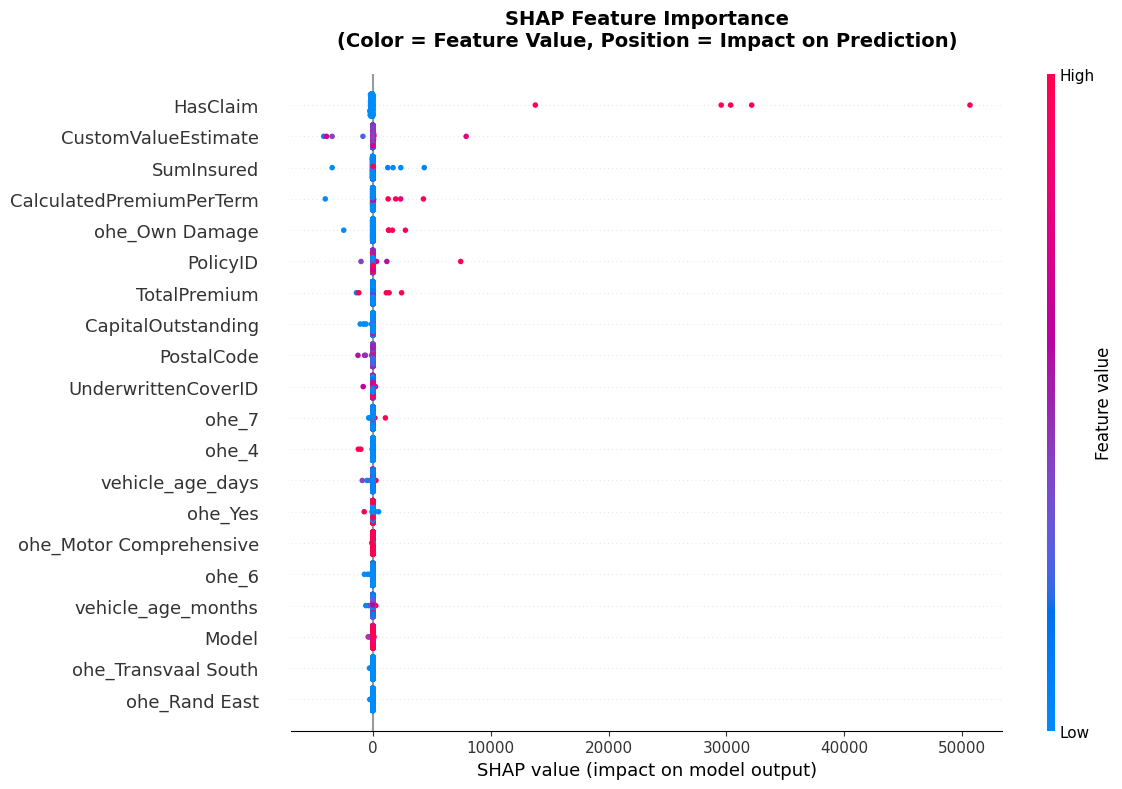


INTERPRETATION:
• Each point represents a sample
• X-axis: SHAP value (impact on model output)
• Y-axis: Features sorted by importance
• Color: Feature value (red = high, blue = low)
• Right side: Increases prediction
• Left side: Decreases prediction



In [43]:
print("\n" + "="*80)
print("SHAP SUMMARY PLOT - Global Feature Impact")
print("="*80)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap_sample, 
                  feature_names=feature_names,
                  show=False,
                  plot_size=(12, 8))

plt.title('SHAP Feature Importance\n(Color = Feature Value, Position = Impact on Prediction)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
INTERPRETATION:
• Each point represents a sample
• X-axis: SHAP value (impact on model output)
• Y-axis: Features sorted by importance
• Color: Feature value (red = high, blue = low)
• Right side: Increases prediction
• Left side: Decreases prediction
""")

### SHAP Dependence Plots for Top Features


SHAP DEPENDENCE PLOTS - Feature Interactions


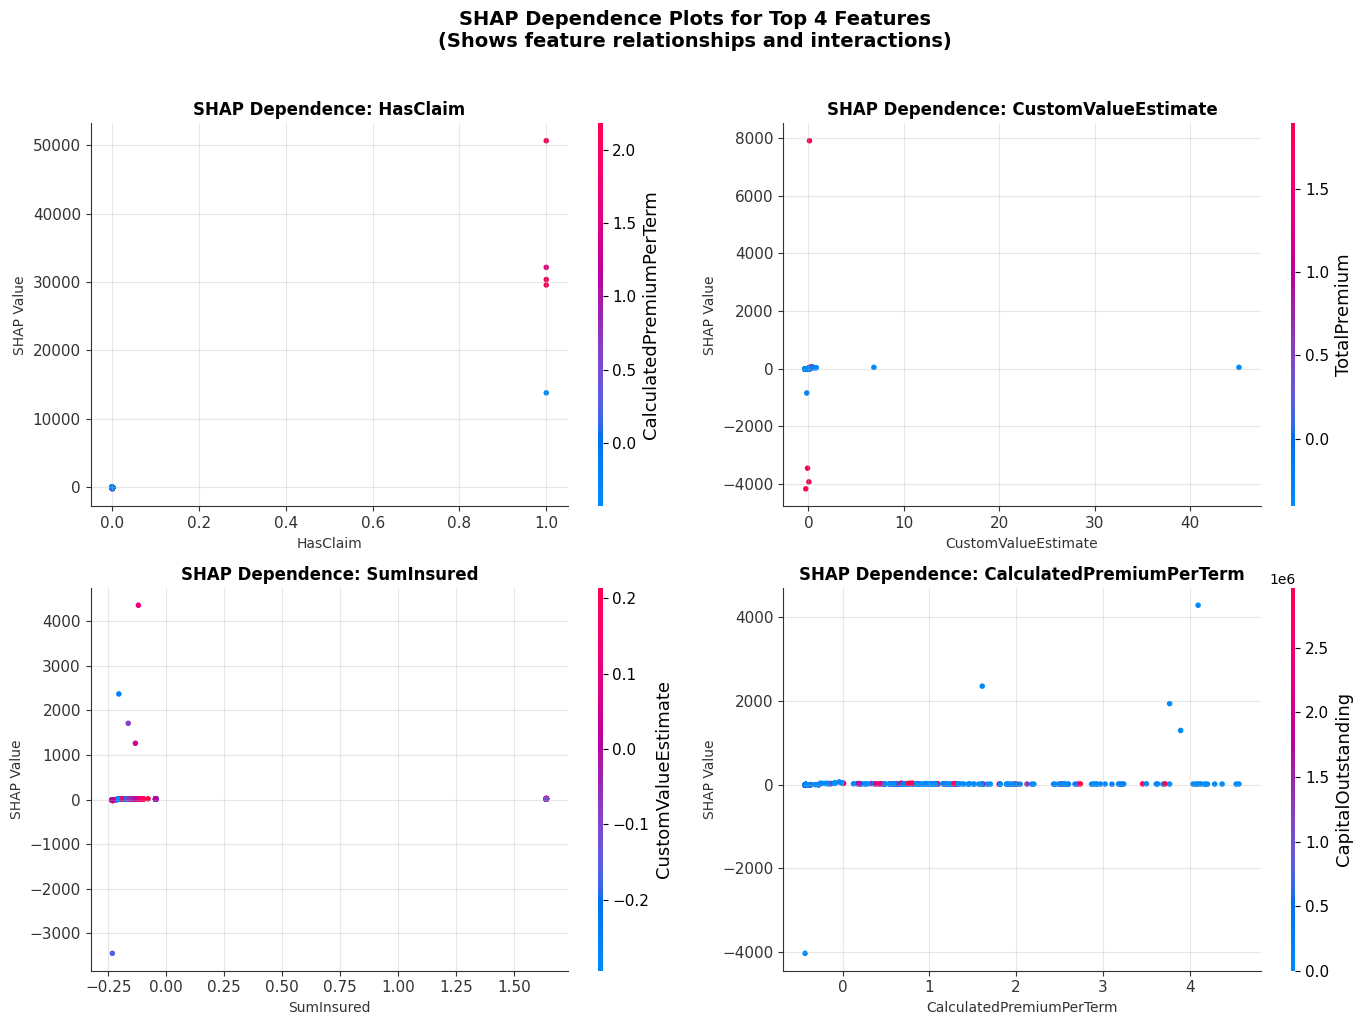


INTERPRETATION:
• Shows how SHAP values change with feature values
• Color shows interaction with most related feature
• Non-linear patterns reveal complex relationships
• Helps understand feature effects across ranges



In [44]:
print("\n" + "="*80)
print("SHAP DEPENDENCE PLOTS - Feature Interactions")
print("="*80)

# Create dependence plots for top 4 features
top_features = shap_importance_df.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Get feature index
    feature_idx = feature_names.index(feature)
    
    # Create dependence plot
    shap.dependence_plot(feature_idx, shap_values, X_shap_sample,
                        feature_names=feature_names,
                        ax=ax,
                        show=False)
    
    ax.set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('SHAP Value', fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('SHAP Dependence Plots for Top 4 Features\n(Shows feature relationships and interactions)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
INTERPRETATION:
• Shows how SHAP values change with feature values
• Color shows interaction with most related feature
• Non-linear patterns reveal complex relationships
• Helps understand feature effects across ranges
""")

### SHAP Waterfall Plot


WATERFALL PLOT - Detailed Prediction Breakdown


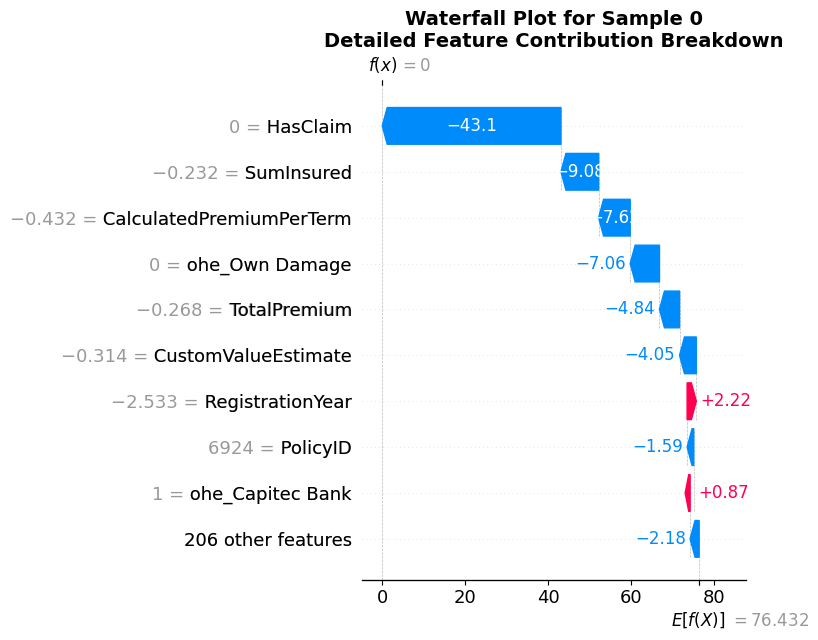


INTERPRETATION:
• Shows exact contribution of each feature
• Starts from base value (average prediction)
• Each bar shows feature's contribution
• Final value is the prediction for this sample



In [46]:
print("\n" + "="*80)
print("WATERFALL PLOT - Detailed Prediction Breakdown")
print("="*80)

# Select an interesting sample
sample_idx = 0  # Change this to explore different samples

# Create waterfall plot
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx],
                                     base_values=explainer.expected_value,
                                     data=X_shap_sample[sample_idx],
                                     feature_names=feature_names),
                   show=False)

plt.title(f'Waterfall Plot for Sample {sample_idx}\nDetailed Feature Contribution Breakdown', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("""
INTERPRETATION:
• Shows exact contribution of each feature
• Starts from base value (average prediction)
• Each bar shows feature's contribution
• Final value is the prediction for this sample
""")